In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time
from scipy.stats import rankdata

In [2]:
def lap_noise(data, epsilon, K, N, M):
    pri_data = data + np.random.laplace(loc = 0.0, scale = (K*(16*N-11)/N)/epsilon, size=data.shape)
    
    min = 10000
    
    for i in range(M):
        if pri_data[i] > 0 and pri_data[i] < min:
            min = pri_data[i]
    
    for i in range(M):
        if pri_data[i] < 0:
            pri_data[i] = min
    
    return pri_data

In [3]:
def total(n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    
    if h == 0:
        return 0
    else:
        return (4*((i-h/4)**2) + 2*((i+j-h/2)**2) + 4*((j-h/4)**2))/h

In [4]:
def f(x, y, theta):
    t = (x - math.sqrt(2)*math.cos(theta))**2 + (y - math.sin(theta))**2
    return math.sqrt(t)

def eDistance(x,y):
    if x != 0:
        roots = np.roots([4, 4*y, 8*x*x + y*y -4, -4*y, -y*y])
        #print(roots)
        theta = np.zeros(9)
        theta[0] = 0
        c = 1
        for i in range(4):
            if roots[i] >= -1 and roots[i] <= 1:
                theta[c] = math.asin(roots[i])
                if theta[c] >= 0:
                    theta[c+1] = math.pi - theta[c]
                else:
                    theta[c+1] = - math.pi - theta[c]
                c += 2
        #print(theta)
        
        distance = 1000000000
        for j in range(c):
            #print(f(x,y,theta[j]))
            if f(x,y,theta[j]) < distance:
                distance = f(x,y,theta[j])
                
    else:
        if y > 0:
            distance = math.fabs(1-y)
        else:
            distance = math.fabs(-1-y)
    return distance

In [5]:
def appx_SHD_total(cc,n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    T = total(n)
    
    if h <= cc:
        s = 2*(i-j)/cc
        t = 2*(i+j-cc/2)/cc
        d = eDistance(s,t)
        if T < cc:
            return -math.ceil((math.sqrt(2)-1)*(cc-h)/(2*math.sqrt(2)) + d*cc/8)
        else:
            return math.ceil((math.sqrt(2)-1)*(cc-h)/(2*math.sqrt(2)) + d*cc/8)-1
    else:
        s = 2*(i-j)/math.sqrt(h*cc)
        t = 2*(i+j-h/2)/math.sqrt(h*cc)
        d = eDistance(s,t)
        if T < cc:
            return -math.ceil(d*math.sqrt(h*cc)/8)
        else:
            return math.ceil(d*math.sqrt(h*cc)/8)-1

In [6]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(shd, m, K, epsilon):
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * shd[i] / (2*K))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
        
        x = random_num(p)
        shd[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

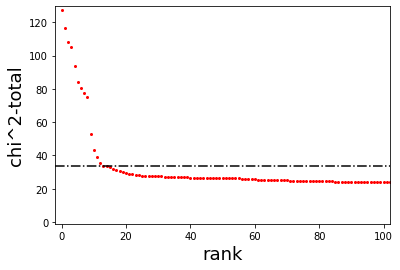

In [7]:
N = 5000
M = 1000000
H = np.zeros(M)
I = np.zeros(M)
J = np.zeros(M)

n = np.zeros((M,10))

for i in range(M-10):
    n[i][4] = np.random.binomial(2*N, 1/5)
    S = np.random.binomial(2*N-n[i][4], 1/4) #n7+n9+n10
    P = np.random.binomial(S, 1/2) #n7+n10
    n[i][6] = np.random.binomial(P, 1/2)
    n[i][9] = P - n[i][6]
    n[i][8] = S - P
    n[i][1] = np.random.binomial(2*N-n[i][4]-S, 1/3)
    T = np.random.binomial(2*N-n[i][4]-n[i][1]-S, 1/2) #n3+n4
    n[i][2] = np.random.binomial(T, 1/2)
    n[i][3] = T - n[i][2]
    R = 2*N-n[i][4]-n[i][1]-S-T
    Q = np.random.binomial(R, 1/2) #n6+n8
    n[i][5] = np.random.binomial(Q, 1/2)
    n[i][7] = Q - n[i][5]
    n[i][0] = R - Q
    
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]
    
for i in range(M-10,M):
    n[i][4] = np.random.binomial(2*N, 1.1/5)
    S = np.random.binomial(2*N-n[i][4], 1/4) #n7+n9+n10
    P = np.random.binomial(S, 1/2) #n7+n10
    n[i][6] = np.random.binomial(P, 1.1/2)
    n[i][9] = P - n[i][6]
    n[i][8] = S - P
    n[i][1] = np.random.binomial(2*N-n[i][4]-S, 1.1/3)
    T = np.random.binomial(2*N-n[i][4]-n[i][1]-S, 1/2) #n3+n4
    n[i][2] = np.random.binomial(T, 1.1/2)
    n[i][3] = T - n[i][2]
    R = 2*N-n[i][4]-n[i][1]-S-T
    Q = np.random.binomial(R, 1/2) #n6+n8
    n[i][5] = np.random.binomial(Q, 1.1/2)
    n[i][7] = Q - n[i][5]
    n[i][0] = R - Q
    
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if H[i] == 0:
        stats[i] = 0
    else:
        stats[i] = (2*((I[i]-J[i])**2))/H[i] + ((2*I[i] + 2*J[i] - H[i])**2)/H[i]

x = np.argsort(stats)
sorted_stats = sorted(stats, reverse=True)

fig = plt.figure()
plt.ylim(-1, max(stats)+2)
plt.xlim(-2, 102)
plt.plot(order, sorted_stats, marker="o", markersize=2, color = "red", linestyle = "None")
plt.axhline(33.6, color = "black", linestyle = "-.")
plt.xlabel("rank", fontsize = 18)
plt.ylabel("chi^2-total", fontsize = 18)
fig.savefig("stats-total.png")
fig.savefig("fig/stats-total.eps")

In [8]:
cc = 33.6
appx_shd = np.zeros(M)

for i in range(M):
    k = [int(n[i][0]), int(n[i][1]), int(n[i][2]), int(n[i][3]), int(n[i][4]), int(n[i][5]), int(n[i][6]), int(n[i][7]), int(n[i][8]), int(n[i][9])]
    appx_shd[i] = appx_SHD_total(cc,k)

print(appx_shd)

<ipython-input-4-93072744abec>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  theta[c] = math.asin(roots[i])


[-43. -73. -61. ...  83.  49.  86.]


In [9]:
def evaluation_Lap(data,epsilon, K, N, M):
    correct = 0
    for j in range(50):
        noisy_stats = lap_noise(np.array(data), epsilon, K, N, M)
        noisy_rank = rankdata(-noisy_stats)
        #print(noisy_rank)
        for i in range(K):
            if noisy_rank[i] <= K:
                correct += 1
        #print(correct)
    accuracy = correct/(K*50)
    return accuracy

In [10]:
def evaluation_Exp(x, appx_shd, epsilon, K, N, M):
    accuracy = 0
    correct = 0
    cc = 33.6
    
    true = np.zeros(K)
    for i in range(K):
        true[i] = x[M-1-i]
        
    APPX = np.zeros(M)
        
    for j in range(50):
            
        for i in range(M):
            APPX[i] = appx_shd[i]
            
        #print(APPX)
        
        appx_result = exp_mec(APPX, M, K, epsilon)
        
        for k in range(K):
            for l in range(K):
                if appx_result[k] == true[l]:
                    correct += 1
        #print(correct)
    accuracy = correct/(K*50)
    return accuracy

[[0.   0.02]
 [0.   1.  ]
 [0.   1.  ]
 [0.94 1.  ]
 [0.98 1.  ]
 [1.   1.  ]
 [1.   1.  ]]
[[0.   0.  ]
 [0.   0.98]
 [0.   1.  ]
 [0.8  1.  ]
 [0.98 1.  ]
 [1.   1.  ]
 [1.   1.  ]]
[[0.   0.  ]
 [0.   0.92]
 [0.   1.  ]
 [0.78 1.  ]
 [0.96 1.  ]
 [1.   1.  ]
 [1.   1.  ]]
[[0.   0.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.82 1.  ]
 [0.98 1.  ]
 [0.98 1.  ]
 [1.   1.  ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.   0.  ]
 [0.   1.  ]
 [0.02 1.  ]
 [0.86 1.  ]
 [0.98 1.  ]
 [1.   1.  ]
 [1.   1.  ]]


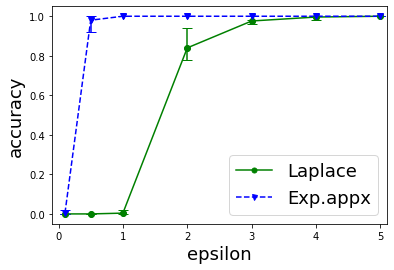

In [11]:
K = 1
N = 5000
M = 1000000

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2))
min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        accuracy[i][1] = evaluation_Exp(x, appx_shd, epsilon[i],K,N,M)
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,2))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_total_K=1.png")
fig.savefig("fig/evaluation_total_K=1.eps")

[[0.   0.  ]
 [0.   0.72]
 [0.   0.77]
 [0.01 0.89]
 [0.21 0.96]
 [0.71 0.98]
 [0.79 1.  ]]
[[0.   0.  ]
 [0.   0.63]
 [0.   0.79]
 [0.   0.88]
 [0.2  0.96]
 [0.63 0.95]
 [0.87 1.  ]]
[[0.   0.  ]
 [0.   0.76]
 [0.   0.87]
 [0.01 0.86]
 [0.23 0.95]
 [0.64 0.98]
 [0.78 0.99]]
[[0.   0.  ]
 [0.   0.82]
 [0.   0.79]
 [0.   0.89]
 [0.14 1.  ]
 [0.7  0.97]
 [0.82 0.98]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.   0.  ]
 [0.   0.72]
 [0.   0.86]
 [0.   0.9 ]
 [0.18 0.98]
 [0.68 0.98]
 [0.87 1.  ]]


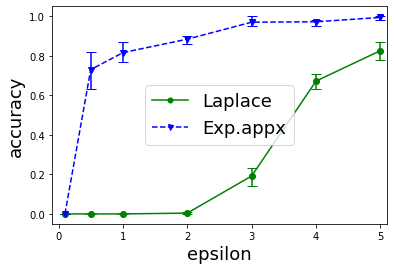

In [12]:
K = 2
N = 5000
M = 1000000

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2))
min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        accuracy[i][1] = evaluation_Exp(x, appx_shd, epsilon[i],K,N,M)
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,2))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_total_K=2.png")
fig.savefig("fig/evaluation_total_K=2.eps")

[[0.         0.        ]
 [0.         0.41333333]
 [0.         0.93333333]
 [0.         0.99333333]
 [0.01333333 1.        ]
 [0.08       1.        ]
 [0.33333333 1.        ]]
[[0.         0.        ]
 [0.         0.42      ]
 [0.         0.91333333]
 [0.00666667 0.99333333]
 [0.         1.        ]
 [0.07333333 1.        ]
 [0.34666667 1.        ]]
[[0.         0.        ]
 [0.         0.42666667]
 [0.         0.91333333]
 [0.         1.        ]
 [0.00666667 1.        ]
 [0.06666667 1.        ]
 [0.35333333 1.        ]]
[[0.         0.        ]
 [0.         0.45333333]
 [0.         0.91333333]
 [0.         0.99333333]
 [0.         1.        ]
 [0.04       1.        ]
 [0.31333333 1.        ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.         0.        ]
 [0.         0.46      ]
 [0.         0.92666667]
 [0.         0.98      ]
 [0.01333333 1.        ]
 [0.08       1.        ]
 [0.32       1.        ]]


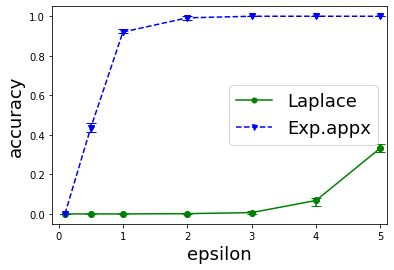

In [13]:
K = 3
N = 5000
M = 1000000

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2))
min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        accuracy[i][1] = evaluation_Exp(x, appx_shd, epsilon[i],K,N,M)
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,2))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_total_K=3.png")
fig.savefig("fig/evaluation_total_K=3.eps")

[[0.    0.   ]
 [0.    0.   ]
 [0.    0.736]
 [0.    0.876]
 [0.    0.916]
 [0.004 0.916]
 [0.004 0.94 ]]
[[0.    0.   ]
 [0.    0.004]
 [0.    0.7  ]
 [0.    0.856]
 [0.    0.904]
 [0.    0.9  ]
 [0.    0.948]]
[[0.    0.   ]
 [0.    0.008]
 [0.    0.704]
 [0.    0.896]
 [0.    0.876]
 [0.008 0.92 ]
 [0.004 0.94 ]]
[[0.    0.   ]
 [0.    0.008]
 [0.    0.68 ]
 [0.    0.856]
 [0.    0.892]
 [0.    0.908]
 [0.012 0.928]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.    0.   ]
 [0.    0.012]
 [0.    0.712]
 [0.    0.876]
 [0.    0.912]
 [0.    0.924]
 [0.004 0.928]]


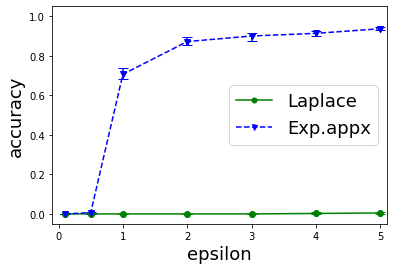

In [14]:
K = 5
N = 5000
M = 1000000

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2))
min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        accuracy[i][1] = evaluation_Exp(x, appx_shd, epsilon[i],K,N,M)
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,2))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_total_K=5.png")
fig.savefig("fig/evaluation_total_K=5.eps")

[[0.    0.   ]
 [0.    0.   ]
 [0.    0.008]
 [0.    0.602]
 [0.    0.944]
 [0.    0.994]
 [0.002 0.998]]
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.008]
 [0.    0.628]
 [0.    0.938]
 [0.    0.986]
 [0.    1.   ]]
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.006]
 [0.    0.622]
 [0.    0.934]
 [0.    0.998]
 [0.    1.   ]]
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.004]
 [0.    0.626]
 [0.    0.938]
 [0.    0.994]
 [0.    0.998]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.    0.   ]
 [0.    0.   ]
 [0.    0.01 ]
 [0.    0.636]
 [0.    0.93 ]
 [0.    0.998]
 [0.    0.998]]


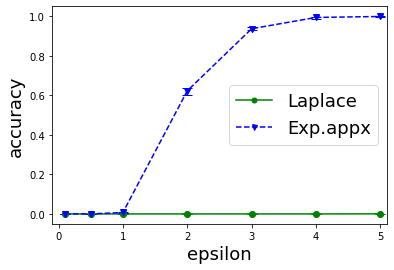

In [15]:
K = 10
N = 5000
M = 1000000

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2))
min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        accuracy[i][0] = evaluation_Lap(sorted_stats,epsilon[i],K,N,M)
        accuracy[i][1] = evaluation_Exp(x, appx_shd, epsilon[i],K,N,M)
        
        if accuracy[i][0] > max_acc[i][0]:
            max_acc[i][0] = accuracy[i][0]
        if accuracy[i][0] < min_acc[i][0]:
            min_acc[i][0] = accuracy[i][0]
        if accuracy[i][1] > max_acc[i][1]:
            max_acc[i][1] = accuracy[i][1]
        if accuracy[i][1] < min_acc[i][1]:
            min_acc[i][1] = accuracy[i][1]
        sum_acc[i][0] += accuracy[i][0]
        sum_acc[i][1] += accuracy[i][1]
    print(accuracy)

accuracy = sum_acc / 5

y_err = np.zeros((2,7,2))

y_err[0,:,0] = accuracy[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - accuracy[:,0]
y_err[0,:,1] = accuracy[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - accuracy[:,1]

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.1, 5.1)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Laplace")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Exp.appx")
plt.legend(fontsize = 18)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("evaluation_total_K=10.png")
fig.savefig("fig/evaluation_total_K=10.eps")